In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
x = np.linspace(0, 50, 501)

In [3]:
y = np.sin(x)

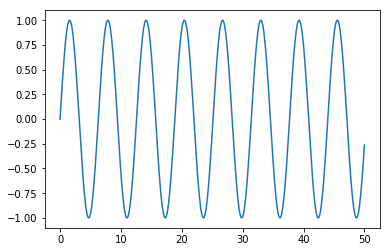

In [4]:
plt.plot(x,y)

In [5]:
df = pd.DataFrame(data = y, index = x, columns=['Sine'])

In [6]:
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [7]:
test_percent = 0.1

In [8]:
len(df)*test_percent

50.1

In [9]:
test_point = np.round(len(df)*test_percent)

In [10]:
test_point

50.0

In [11]:
test_ind = int(len(df)-test_point)
test_ind

451

In [12]:
train = df.iloc[:test_ind]

In [13]:
test = df.iloc[test_ind:]

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train = scaler.transform(train)

In [17]:
scaled_test = scaler.transform(test)

In [18]:
length = 50
batch_size = 1

In [19]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length = length, batch_size=batch_size)

In [20]:
n_features = 1

In [21]:
model = Sequential()

In [22]:
model.add(SimpleRNN(50, input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit_generator(generator, epochs = 5)

Epoch 1/5
401/401 [==============================] - 25s 63ms/step - loss: 0.0117
Epoch 2/5
401/401 [==============================] - 40s 99ms/step - loss: 0.0013
Epoch 3/5
401/401 [==============================] - 37s 91ms/step - loss: 1.4018e-04
Epoch 4/5
401/401 [==============================] - 29s 73ms/step - loss: 2.9495e-06
Epoch 5/5
401/401 [==============================] - 29s 71ms/step - loss: 6.8880e-06


In [25]:
losses = pd.DataFrame(model.history.history)

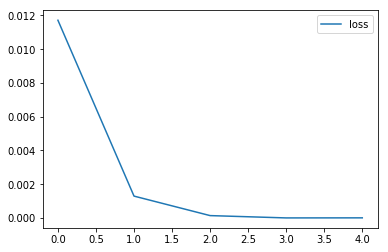

In [26]:
losses.plot()

In [27]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_predict = model.predict(current_batch)[0]
    test_predictions.append(current_predict)
    current_batch = np.append(current_batch[:,1:,:],[[current_predict]] ,axis = 1)

In [28]:
true_predictions = scaler.inverse_transform(test_predictions)

In [29]:
test['predictions'] = true_predictions

/home/sinisha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


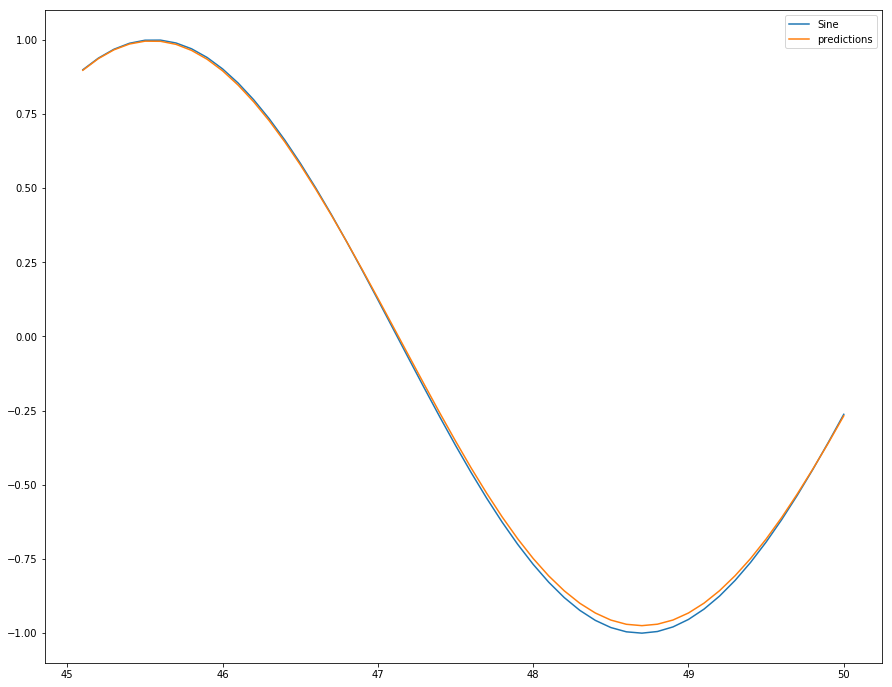

In [30]:
test.plot(figsize=(15,12))

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [32]:
length =  49
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=batch_size)

In [33]:
model = Sequential()
model.add(LSTM(50, input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit_generator(generator, epochs = 20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
402/402 [==============================] - 48s 119ms/step - loss: 0.0194 - val_loss: 1.8425e-04
Epoch 2/20
402/402 [==============================] - 48s 120ms/step - loss: 1.8484e-04 - val_loss: 9.3316e-05
Epoch 3/20
402/402 [==============================] - 62s 155ms/step - loss: 8.2444e-05 - val_loss: 3.6613e-05
Epoch 4/20
402/402 [==============================] - 68s 168ms/step - loss: 2.2024e-04 - val_loss: 6.3326e-04
Epoch 5/20
402/402 [==============================] - 59s 146ms/step - loss: 1.7301e-04 - val_loss: 5.1519e-06
Epoch 6/20
402/402 [==============================] - 73s 182ms/step - loss: 6.7532e-05 - val_loss: 6.4434e-06
Epoch 7/20
402/402 [==============================] - 88s 220ms/step - loss: 8.9388e-05 - val_loss: 2.9822e-07
Epoch 8/20
402/402 [==============================] - 75s 186ms/step - loss: 2.1939e-04 - val_loss: 1.7259e-04
Epoch 9/20
402/402 [==============================] - 45s 112ms/step - loss: 4.6520e-05 - val_loss: 9.1079e-06


In [36]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_predict = model.predict(current_batch)[0]
    test_predictions.append(current_predict)
    current_batch = np.append(current_batch[:,1:,:],[[current_predict]] ,axis = 1)

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test['lstm_predictions'] = true_predictions

/home/sinisha/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


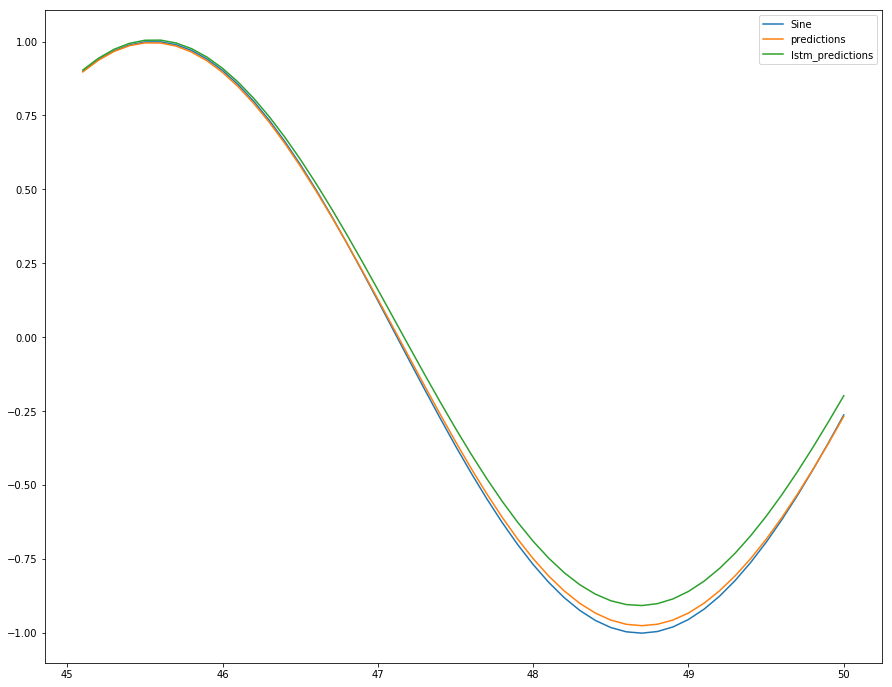

In [40]:
test.plot(figsize=(15,12))

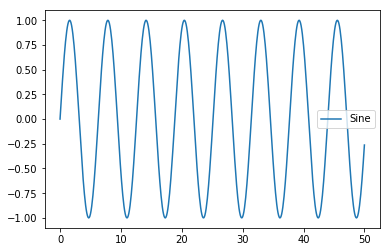

In [42]:
df.plot()

In [43]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [44]:
generator = TimeseriesGenerator(scaled_full_data,scaled_full_data, length=length, batch_size=batch_size)

In [45]:
model = Sequential()
model.add(LSTM(50, input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [46]:
model.fit_generator(generator, epochs=6)

Epoch 1/6
452/452 [==============================] - 64s 141ms/step - loss: 0.0089
Epoch 2/6
452/452 [==============================] - 129s 286ms/step - loss: 3.6643e-04
Epoch 3/6
452/452 [==============================] - 72s 160ms/step - loss: 1.7315e-04
Epoch 4/6
452/452 [==============================] - 66s 145ms/step - loss: 3.0788e-04
Epoch 5/6
452/452 [==============================] - 82s 181ms/step - loss: 5.8062e-05
Epoch 6/6
452/452 [==============================] - 55s 122ms/step - loss: 1.4432e-04


In [54]:
test_predictions = []
#first_eval_batch = scaled_train[-length:]
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1,length,n_features))

for i in range(25):
    current_predict = model.predict(current_batch)[0]
    test_predictions.append(current_predict)
    current_batch = np.append(current_batch[:,1:,:],[[current_predict]] ,axis = 1)

In [55]:
forecast_predictions = scaler.inverse_transform(test_predictions)

In [56]:
forecast_index = np.arange(50.1, 52.6, step=0.1)

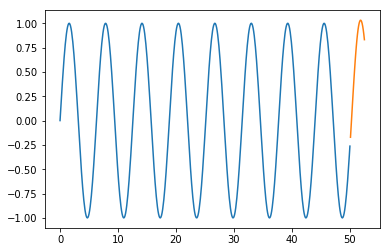

In [59]:
plt.plot(df.index, df['Sine'])
plt.plot(forecast_index, forecast_predictions)